In [37]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [2]:
raw_train = pd.read_csv('data/train.csv')
raw_test = pd.read_csv('data/test.csv')
print raw_train.shape
print raw_train.head()

(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2 

In [3]:
# get columns with too many (>10%) null values
nas = raw_train.isnull().sum()
nas_nulls = nas[nas>raw_train.shape[0]/10]
print "Train columns that should be removed\n",nas_nulls

nast = raw_test.isnull().sum()
nast_nulls = nast[nast>raw_test.shape[0]/10]
print "Test columns that should be removed\n",nast_nulls
nancols = nas_nulls.index.tolist()

Train columns that should be removed
LotFrontage     259
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64
Test columns that should be removed
LotFrontage     227
Alley          1352
FireplaceQu     730
PoolQC         1456
Fence          1169
MiscFeature    1408
dtype: int64


In [4]:
processed_data = raw_train.drop(set(nancols),1)
processed_data = processed_data.drop('Id',1)
test_processed = raw_test.drop(set(nancols),1)
test_processed = test_processed.drop('Id',1)

(1460, 4) (1459, 4)
(1460, 64)
(1459, 63)


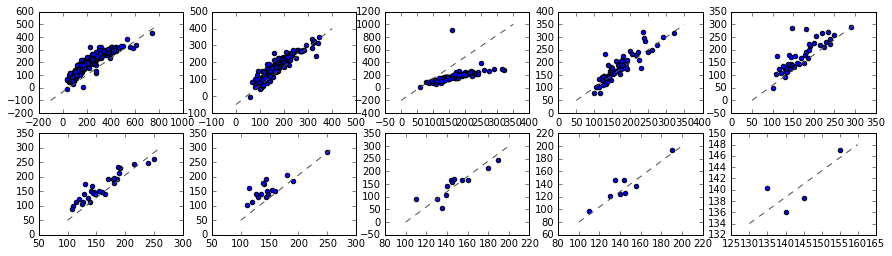

In [60]:
# first quickly pick out columns with integer types
types = processed_data.dtypes
ints = types[types == 'int64'].index.tolist()
numericals = processed_data[ints]
test_numericals = test_processed[numericals.columns[:-1]]
test_numericals = test_numericals.fillna(test_numericals.mean())
cat = ['BldgType','Condition1','Condition2','RoofMatl']
categoricals = processed_data[cat]
test_categoricals = test_processed[cat]
print categoricals.shape,test_categoricals.shape
all_cat = pd.concat([categoricals,test_categoricals])
all_cat = all_cat.apply(lambda x:x.fillna(x.value_counts().index[0]))

all_cat = pd.get_dummies(all_cat)
train_cat = all_cat.iloc[:1460,:]
test_cat = all_cat.iloc[1460:,:]

train_all = pd.concat([train_cat,numericals],axis=1, join='inner')
test_all = pd.concat([test_cat,test_numericals],axis=1, join='inner')
#train_all = numericals
#test_all = test_numericals
print train_all.shape
print test_all.shape


tmp = numericals.as_matrix()
tmpt = test_numericals.as_matrix()
tmp = train_all.as_matrix()
tmpt = test_all.as_matrix()

x = tmp[:,:-1]
y = tmp[:,-1]/1000

x_normed = x #(x - x.mean(axis=0))/x.std(axis=0)
test_normed = tmpt #(tmpt - tmpt.mean(axis=0))/tmpt.std(axis=0)


x_train, x_test, y_train, y_test = train_test_split(x_normed, y, test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

lr = linear_model.LinearRegression()
lr.fit(x_train,y_train.ravel().T)

times=1

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        lr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = lr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1

In [9]:
'''
f, axarr = plt.subplots(6,6, figsize=(18,12))
plt.subplots_adjust( hspace=0.3 )
plt.subplots_adjust( wspace=0.04 )
counter = 0
for i in range(6):
    for j in range(6):
        axarr[i][j].get_yaxis().set_ticks([])
        axarr[i][j].get_xaxis().set_ticks([])
        if counter >= numericals.shape[1]-1:
            continue
        else:
            axarr[i][j].scatter(x_normed[:,counter], y,alpha=0.5)
            axarr[i][j].set_title(numericals.columns[counter])
            counter += 1
'''

'\nf, axarr = plt.subplots(6,6, figsize=(18,12))\nplt.subplots_adjust( hspace=0.3 )\nplt.subplots_adjust( wspace=0.04 )\ncounter = 0\nfor i in range(6):\n    for j in range(6):\n        axarr[i][j].get_yaxis().set_ticks([])\n        axarr[i][j].get_xaxis().set_ticks([])\n        if counter >= numericals.shape[1]-1:\n            continue\n        else:\n            axarr[i][j].scatter(x_normed[:,counter], y,alpha=0.5)\n            axarr[i][j].set_title(numericals.columns[counter])\n            counter += 1\n'

In [57]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

print x_normed.shape
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(x_normed,y.ravel().T)
#print test_all.columns.tolist()
print sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), test_all.columns.tolist()))



(1460L, 63L)
[(1.0, 'Condition2_PosN'), (2.0, '1stFlrSF'), (3.0, '2ndFlrSF'), (4.0, 'TotalBsmtSF'), (5.0, 'LowQualFinSF'), (6.0, 'GrLivArea'), (7.0, 'BsmtFinSF1'), (8.0, 'BsmtUnfSF'), (9.0, 'BsmtFinSF2'), (10.0, 'Condition2_RRAe'), (11.0, 'Condition2_RRAn'), (12.0, 'Condition2_Artery'), (13.0, 'Condition2_Feedr'), (14.0, 'Condition2_Norm'), (15.0, 'Condition2_RRNn'), (16.0, 'Condition2_PosA'), (17.0, 'RoofMatl_WdShngl'), (18.0, 'RoofMatl_Membran'), (19.0, 'RoofMatl_Metal'), (20.0, 'RoofMatl_CompShg'), (21.0, 'RoofMatl_WdShake'), (22.0, 'RoofMatl_Tar&Grv'), (23.0, 'RoofMatl_Roll'), (24.0, 'RoofMatl_ClyTile'), (25.0, 'KitchenAbvGr'), (26.0, 'Condition1_Artery'), (27.0, 'Condition1_RRAe'), (28.0, 'Condition1_PosN'), (29.0, 'Condition1_PosA'), (30.0, 'Condition1_Feedr'), (31.0, 'Condition1_RRNn'), (32.0, 'Condition1_RRAn'), (33.0, 'Condition1_Norm'), (34.0, 'Condition1_RRNe'), (35.0, 'OverallQual'), (36.0, 'BldgType_Twnhs'), (37.0, 'GarageCars'), (38.0, 'BldgType_TwnhsE'), (39.0, 'BedroomA

C:\Users\d\Anaconda2\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


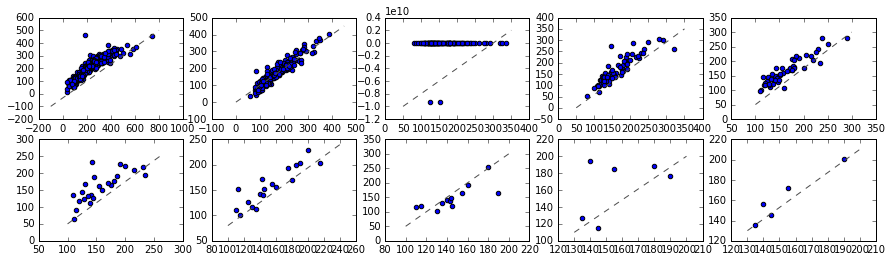

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_normed, y, test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

lr = linear_model.LinearRegression()
lr.fit(x_train,y_train.ravel().T)

times=1

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        lr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = lr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1

In [12]:
print test_normed[660:670,:1]

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [28]:
pred_t = lr.predict(test_normed)
print pred_t
output = raw_test[['Id']]
output['SalePrice']=pred_t*1000

[ 100.58979797  161.99578857  178.02456665 ...,  178.85318375   98.35609055
  257.88291168]


C:\Users\d\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
print output.head()
output = output.applymap(abs)
output.to_csv("prediction.csv",index=False)

     Id      SalePrice
0  1461  100589.797974
1  1462  161995.788574
2  1463  178024.566650
3  1464  204030.467987
4  1465  200797.172546
